In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("Dataset_RF.csv", index_col=0)
data.index = pd.to_datetime(data.index, format="%d/%m/%y %H:%M")

In [3]:
data.head()

,Conso
2023-08-01 00:00:00,200.537021
2023-08-01 01:00:00,139.358464
2023-08-01 02:00:00,374.579284
2023-08-01 03:00:00,347.784869
2023-08-01 04:00:00,282.265648


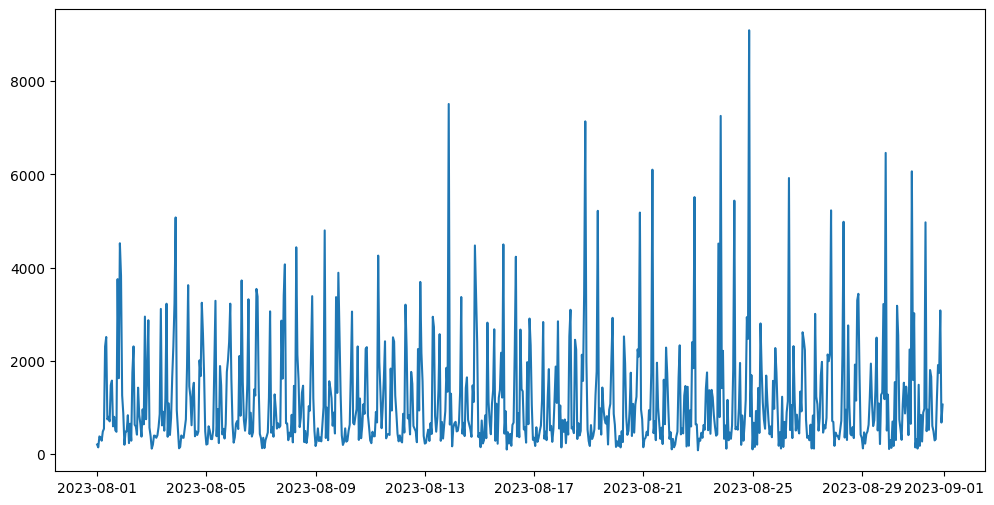

In [6]:
fig, axs = plt.subplots(figsize=(12,6))
axs.plot(data)

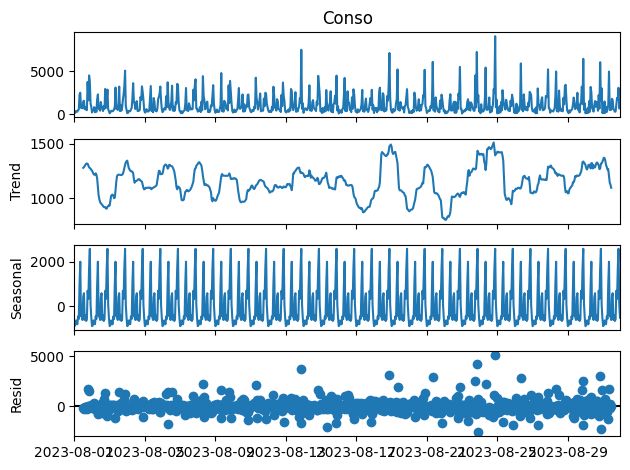

In [36]:
decomposed = sm.tsa.seasonal_decompose(data["Conso"])
decomposed.plot()
plt.show()

In [65]:
fft_result = np.fft.fft(data.Conso.values)[1:]
frequencies = np.fft.fftfreq(len(data.Conso.values))[1:]

# Step 3: Identify Peak Frequency
indices = np.argsort(np.abs(fft_result))  # Indices from lowest to highest Fourier magnitudes
peak_frequency = np.abs(frequencies[indices[-1]])  # Peak frequency is the one with the highest magnitude

# Step 4: Calculate Period
period = 1 / peak_frequency

print(f"La période de la série est: {round(period)}")

La période de la série est: 12


<Axes: >

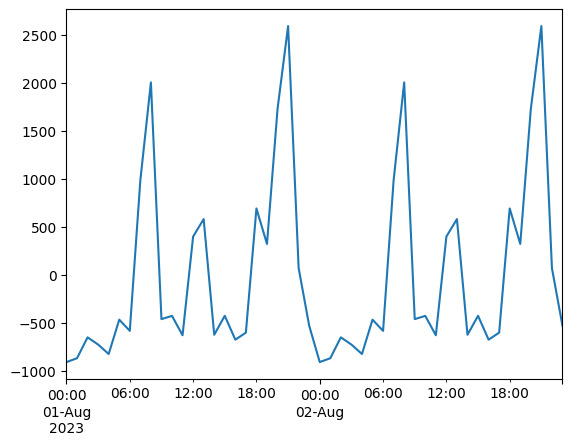

In [63]:
decomposed.seasonal[:12*4].plot()

## Test de stationnarité

In [7]:
adf = adfuller(data["Conso"].to_numpy())
print(f"P-Value du test ADF: {adf[1]}")

P-Value du test ADF: 7.883476425361957e-19


In [8]:
kpss_test = kpss(data["Conso"].to_numpy())
print(f"P-Value du test KPSS: {kpss_test[1]}")

P-Value du test KPSS: 0.1


C:\Users\raves\AppData\Local\Temp\ipykernel_5536\2021430437.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(data["Conso"].to_numpy())


##### La série semble donc bien stationnaire

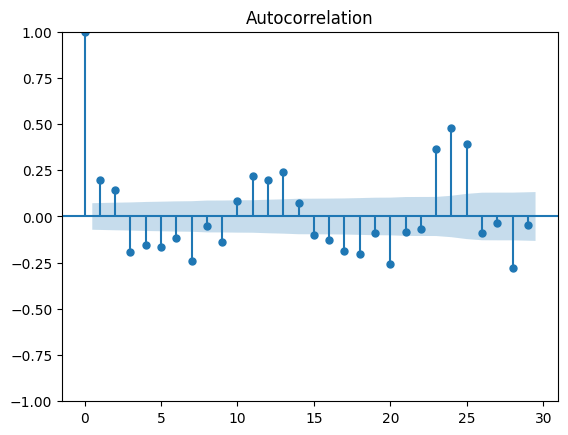

In [14]:
sm.graphics.tsa.plot_acf(data["Conso"].values.squeeze())
plt.show()

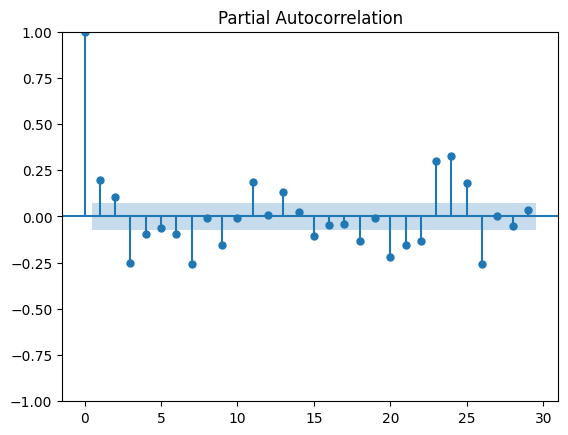

In [15]:
sm.graphics.tsa.plot_pacf(data["Conso"].values.squeeze())
plt.show()

## Modélisation

In [66]:
train, test = train_test_split(data.to_numpy(), test_size=len(data)//4)

In [68]:
auto_model = pm.auto_arima(train, seasonal=True, m=12, trace=True, n_jobs=4)

C:\Users\raves\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9305.878, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9425.764, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9393.212, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9401.982, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9810.969, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=9370.355, Time=0.25 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=9369.042, Time=0.28 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=9214.083, Time=1.99 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=9278.348, Time=1.68 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=9247.053, Time=1.78 sec
 ARIMA(2,0,1)(1,0,2)[12] intercept   : AIC=9246.064, Time=1.60 sec
 ARIMA(3,0,2)(1,0,2)[12] intercept   : AIC=9225.276, Time=2.07 sec
 ARIMA(2,0,3)(1,0,2)[12] inte

Best model:  ARIMA(2,0,5)(2,0,0)[12] intercept

Total fit time: 89.543 seconds

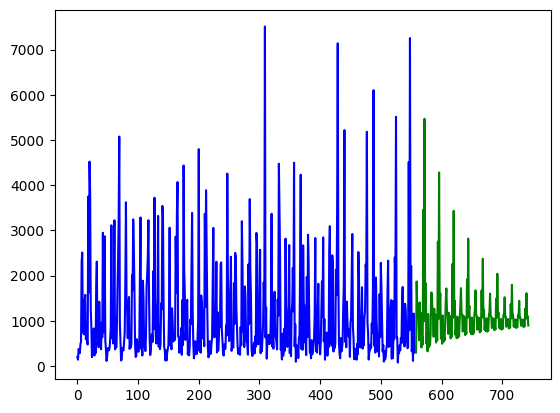

RMSE 1235.092401829405


In [77]:
# make your forecasts
forecasts = auto_model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(len(data))
plt.plot(x[:train.shape[0]], train, c='blue')
plt.plot(x[train.shape[0]:], forecasts, c='green')
plt.show()

print(f"RMSE {np.sqrt(mean_squared_error(test, forecasts))}")

C:\Users\raves\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


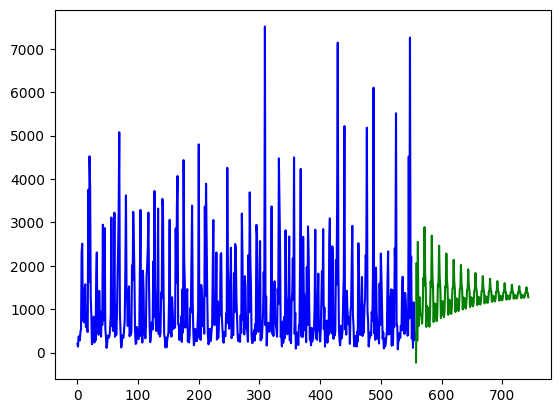

MSE 1510598.1030319114


In [75]:
model_manu = pm.ARIMA(order=(2,0,7),seasonal_order=(1,0,3, 12))
model_manu.fit(train)
# make your forecasts
forecasts = model_manu.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(len(data))
plt.plot(x[:train.shape[0]], train, c='blue')
plt.plot(x[train.shape[0]:], forecasts, c='green')
plt.show()

print(f"MSE {mean_squared_error(test, forecasts)}")

## Prophet

In [79]:
from prophet import Prophet

In [100]:
train_df = pd.DataFrame(train, columns=['y'])
train_df['ds'] = data.index[:len(train)].dt.to_pydatetime()
# data['ds'] = data.index
# data = data.rename(columns={'Conso': 'y'})

AttributeError: 'DatetimeIndex' object has no attribute 'dt'

In [90]:
m = Prophet()
m.fit(train_df)

10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
# Python
future = m.make_future_dataframe(periods=len(test)//12, freq='H')
future.tail()

,ds
568,2023-08-24 16:00:00
569,2023-08-24 17:00:00
570,2023-08-24 18:00:00
571,2023-08-24 19:00:00
572,2023-08-24 20:00:00


In [99]:
train_df

,y,ds
0,200.537021,2023-08-01 00:00:00
1,139.358464,2023-08-01 01:00:00
2,374.579284,2023-08-01 02:00:00
3,347.784869,2023-08-01 03:00:00
4,282.265648,2023-08-01 04:00:00
...,...,...
553,111.675283,2023-08-24 01:00:00
554,1158.901220,2023-08-24 02:00:00
555,291.967777,2023-08-24 03:00:00
556,457.218459,2023-08-24 04:00:00


In [95]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
568,2023-08-24 16:00:00,146.173456,-908.880141,1174.687310
569,2023-08-24 17:00:00,300.244350,-687.148133,1347.163936
570,2023-08-24 18:00:00,1237.657749,219.658756,2289.906755
571,2023-08-24 19:00:00,2383.523018,1265.493320,3448.330928
572,2023-08-24 20:00:00,2935.594436,1993.490653,4020.360400


C:\Users\raves\anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\raves\anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

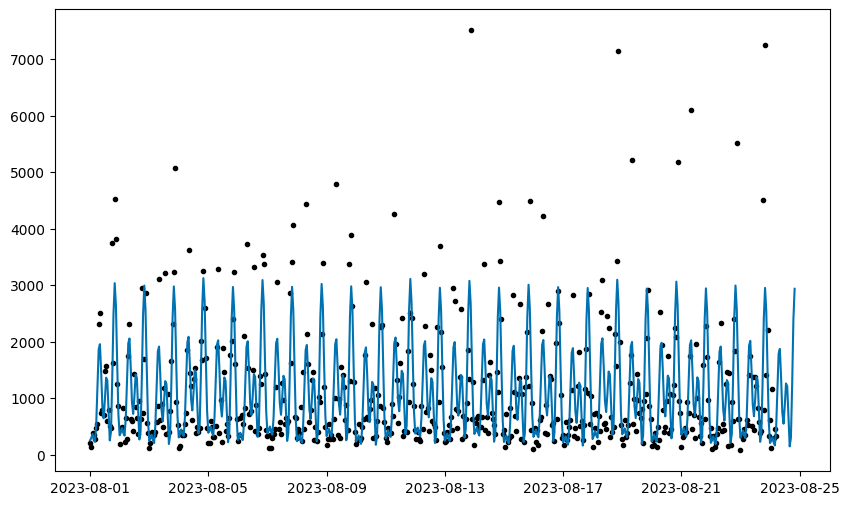

In [96]:
# Python
fig1 = m.plot(forecast)